In [43]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.preprocessing import LabelEncoder


TEST_IDENTITY = 'test_identity.csv'
TEST_TRANSACTION = 'test_transaction.csv'
TRAIN_IDENTITY = 'train_identity.csv'
TRAIN_TRANSACTION = 'train_transaction.csv'
SAMPLE_SUBMISSION = 'sample_submission.csv'
USELESS_COLOUMNS = ['TransactionID', 'V1', 'V2', 'V3', 'V4', 'V5', 
                    'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'D11', 
                    'dist1', 'DeviceInfo','DeviceType', 'id_33','id_34', 
                    'id_30','id_31','R_emaildomain','C5','C9',
                    'V12','V13','V29', 'V30','V35','V36','V48','V49','V53',#zero
                    'V54','V69','V70','V75','V76','V90','V91','V107','V305', #zero
                   'P_emaildomain','M1']


In [2]:
test_identity_df = pd.read_csv(TEST_IDENTITY)
test_transaction_df = pd.read_csv(TEST_TRANSACTION)
train_identity_df = pd.read_csv(TRAIN_IDENTITY)
train_transaction_df = pd.read_csv(TRAIN_TRANSACTION)

In [3]:
# train_identity_df.isnull().sum()

## Preprocessing

In [103]:
def process1 (identity_df, transaction_df) :
#     return transaction_df
    df = pd.merge(identity_df, transaction_df, on= 'TransactionID', how='right')
    df = df.drop(USELESS_COLOUMNS, axis = 1)
    return df
    
def process2(df):
    
    num_df = df.select_dtypes(exclude =['object'])
    num_df = num_df.fillna(TRAIN_MEAN)
    num_df = normalizeData(num_df)
    obj_df = df.select_dtypes(include = 'object')
    print("OHE columns = ", obj_df.columns)
    obj_df_OHE = pd.get_dummies(obj_df)
    return num_df.join(obj_df_OHE)
    
    
def getBalancedData(df):
    positive_data_df = df[data_df.isFraud == 1]
    negative_data_df = df[data_df.isFraud == 0]
    return positive_data_df.append(negative_data_df[0:25318])#11318

def normalizeData(df) :
    return (df - TRAIN_MIN)/(TRAIN_MAX - TRAIN_MIN)


In [104]:

data_df = process1(train_identity_df, train_transaction_df)
balanced_data_df = getBalancedData(data_df)

In [105]:
num_df = balanced_data_df.drop('isFraud', axis = 1).select_dtypes(exclude =['object'])
num_df = num_df.fillna(num_df.mean())
TRAIN_MEAN = num_df.mean()
TRAIN_MIN = num_df.min()
TRAIN_MAX = num_df.max()


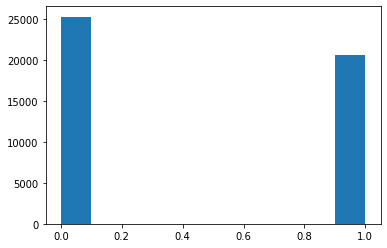

In [106]:
train_y = balanced_data_df.isFraud
plt.hist(balanced_data_df.isFraud)
balanced_data_df = balanced_data_df.drop('isFraud', axis = 1)

# plt.hist(balanced_data_df.isFraud)

In [107]:
train_df = process2(balanced_data_df)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_y, test_size=0.3, random_state = 2)

(array([17670.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14516.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

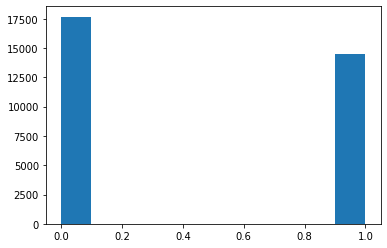

In [111]:
plt.hist(y_train)

In [119]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# classifier = LogisticRegression()
classifier = MultinomialNB(class_prior=[.5, .5], fit_prior=False)
# classifier = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)

classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=False)

In [128]:
from sklearn import metrics
from sklearn.metrics import f1_score
def evaluate_model():
    predicted = classifier.predict(X_test)
    # Model Accuracy
    print("Accuracy:",metrics.accuracy_score(y_test, predicted))
    print("Precision:",metrics.precision_score(y_test, predicted))
    print("Recall:",metrics.recall_score(y_test, predicted))
    print("Confusion Matrix: ", metrics.confusion_matrix(y_test, predicted))
    print("F score: ", metrics.f1_score(y_test, predicted))
#     print("AUC: ", metrics.auc(y_test, predicted))
    return predicted

In [129]:
val_predictions = evaluate_model()

Accuracy: 0.8384922073214933
Precision: 0.8375538329026702
Recall: 0.7909549373678217
Confusion Matrix:  [[6705  943]
 [1285 4862]]
F score:  0.8135876840696119


In [122]:
temp = pd.DataFrame(classifier.predict_proba(X_test))
# temp['pred'] = 
temp['y_test'] = val_predictions
# temp.head(50)
# val_predictions
# y_test
# temp['pred'] = val_predictions
# temp.head(30)
# y_test.isnull().sum()
# display(y_test)

## Create Submission

In [123]:
eval_raw_df = process1(test_identity_df, test_transaction_df)
eval_df = process2(eval_raw_df)

In [130]:
predictions = classifier.predict_proba(eval_df)

(array([6.05500e+03, 1.98800e+03, 1.72800e+03, 8.36000e+02, 3.28000e+02,
        7.44000e+02, 3.48700e+03, 7.07100e+03, 2.64870e+04, 4.57967e+05]),
 array([1.01204363e-05, 1.00009108e-01, 2.00008096e-01, 3.00007084e-01,
        4.00006072e-01, 5.00005060e-01, 6.00004048e-01, 7.00003036e-01,
        8.00002024e-01, 9.00001012e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

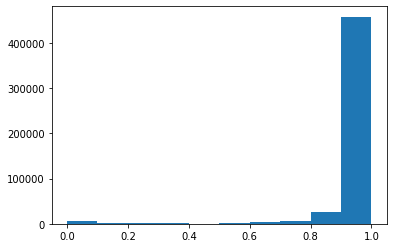

In [131]:
plt.hist(predictions[:,1])

In [222]:
submission_df = pd.DataFrame()
submission_df['TransactionID'] = test_transaction_df.TransactionID
submission_df['isFraud'] = predictions[:,1]

In [223]:
submission_df.head(100)

,TransactionID,isFraud
0,3663549,0.98
1,3663550,0.53
2,3663551,0.75
3,3663552,0.93
4,3663553,0.96
5,3663554,0.78
6,3663555,0.78
7,3663556,0.85
8,3663557,0.67
9,3663558,0.65


In [153]:
# submission_df.to_csv('submission22_Sept_1818.csv', index=False)

In [171]:
submission_df.shape

(506691, 2)

In [179]:
abc = ['a', 'b', 'c']
cba = ['c','b','a']
rr = pd.DataFrame()
rr['abc'] = abc
rr['cba'] = cba
pd.get_dummies(rr)
# rr

,abc_a,abc_b,abc_c,cba_a,cba_b,cba_c
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,1,0,0
